# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [12]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

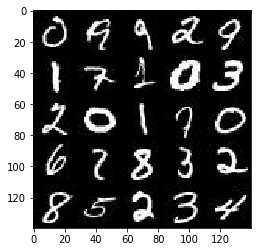

In [13]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

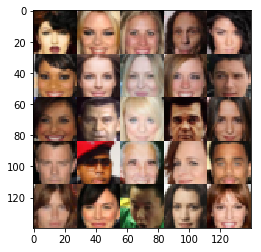

In [14]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [16]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32,(None,image_width,image_height,image_channels),name="realInput")
    fake_input = tf.placeholder(tf.float32,(None,z_dim),name="fakeInput")
    lr = tf.placeholder(tf.float32, name="learningRate")

    return real_input, fake_input, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/carnd/anaconda3/envs/dlenvclone/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/carnd/anaconda3/envs/dlenvclone/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/carnd/anaconda3/envs/dlenvclone/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>\n    app.launch_new_instance()', 'File "/home/carnd/anaconda3/envs/dlenvclone/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/carnd/anaconda3/envs/dlenvclone/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start\n    ioloop.IOLoop.instance().start()

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [17]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        x = tf.layers.conv2d(images,128,5,strides=2,padding='same')
        x = tf.maximum(x*alpha,x)
        
        x1 = tf.layers.conv2d(x,256,5,strides=2,padding='same')
        x1 = tf.layers.batch_normalization(x1)
        x1 = tf.maximum(x1*alpha,x1)
        
        '''x2 = tf.layers.conv2d(x1,,5,strides=2,padding='same')
        x2 = tf.layers.batch_normalization(x2)
        x2 = tf.maximum(x2*alpha,x2)'''
        
        flat = tf.reshape(x1,(-1,7*7*256))        
        logits = tf.layers.dense(flat,1,activation=None)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [18]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2

    with tf.variable_scope('generator',reuse = not is_train):
    
        x = tf.layers.dense(z,(7*7*256),activation=None)
        
        x1 = tf.reshape(x,(-1,7,7,256))
        x1 = tf.layers.batch_normalization(x1,training=is_train)
        x2 = tf.maximum(alpha*x1,x1)
        
        '''x2 = tf.layers.conv2d_transpose(x1,256,5,strides=2,padding='same')
        x2 = tf.layers.batch_normalization(x2,training=is_train)
        x2 = tf.maximum(alpha*x2,x2)'''
        
        x3 = tf.layers.conv2d_transpose(x2,128,5,strides=2,padding='same')
        x3 = tf.layers.batch_normalization(x3,training=is_train)
        x3 = tf.maximum(alpha*x3,x3)
        
        logits = tf.layers.conv2d_transpose(x3,out_channel_dim,5,strides=2,padding='same')
  
        out = tf.tanh(logits)   
    
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [19]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [20]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [21]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(generator(input_z, out_channel_dim, is_train=False), feed_dict={input_z: example_z})
    

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()
  

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [22]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print(data_shape)
    tf.reset_default_graph()
    image_width = data_shape[1]
    image_height = data_shape[2]
    input_real, input_z, lr = model_inputs(image_width, image_height, data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    saver = tf.train.Saver()
    steps = 0
    
    print_every=20
    show_every = 200
    
    losses = []    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=[batch_size, z_dim])
                batch_images = batch_images * 2
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, lr:learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    _ = show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                    
                    
            saver.save(sess, './checkpoints/generator.ckpt')




### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1)
Epoch 1/2... Discriminator Loss: 1.1301... Generator Loss: 0.6125
Epoch 1/2... Discriminator Loss: 1.2916... Generator Loss: 0.6781
Epoch 1/2... Discriminator Loss: 1.5210... Generator Loss: 0.5601
Epoch 1/2... Discriminator Loss: 1.1318... Generator Loss: 0.7826
Epoch 1/2... Discriminator Loss: 1.3037... Generator Loss: 0.7415
Epoch 1/2... Discriminator Loss: 1.3278... Generator Loss: 0.9145
Epoch 1/2... Discriminator Loss: 1.3578... Generator Loss: 0.6849
Epoch 1/2... Discriminator Loss: 1.3405... Generator Loss: 0.7191
Epoch 1/2... Discriminator Loss: 1.3225... Generator Loss: 0.7386
Epoch 1/2... Discriminator Loss: 1.2993... Generator Loss: 0.6887


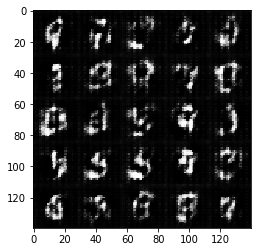

Epoch 1/2... Discriminator Loss: 1.3201... Generator Loss: 0.7215
Epoch 1/2... Discriminator Loss: 1.4001... Generator Loss: 0.6982
Epoch 1/2... Discriminator Loss: 1.4011... Generator Loss: 0.6108
Epoch 1/2... Discriminator Loss: 1.2034... Generator Loss: 0.7637
Epoch 1/2... Discriminator Loss: 1.3153... Generator Loss: 0.7593
Epoch 1/2... Discriminator Loss: 1.5045... Generator Loss: 0.9098
Epoch 1/2... Discriminator Loss: 1.2703... Generator Loss: 0.9114
Epoch 1/2... Discriminator Loss: 1.2842... Generator Loss: 0.7645
Epoch 1/2... Discriminator Loss: 1.1451... Generator Loss: 0.7971
Epoch 1/2... Discriminator Loss: 1.3421... Generator Loss: 0.9511


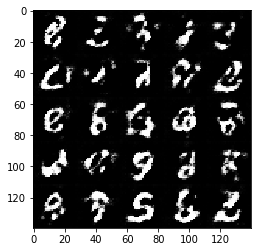

Epoch 1/2... Discriminator Loss: 1.3503... Generator Loss: 0.7572
Epoch 1/2... Discriminator Loss: 1.1860... Generator Loss: 0.8049
Epoch 1/2... Discriminator Loss: 1.2846... Generator Loss: 0.9699
Epoch 2/2... Discriminator Loss: 1.1981... Generator Loss: 0.7991
Epoch 2/2... Discriminator Loss: 1.1948... Generator Loss: 0.6296
Epoch 2/2... Discriminator Loss: 1.2189... Generator Loss: 1.0606
Epoch 2/2... Discriminator Loss: 1.1886... Generator Loss: 0.8953
Epoch 2/2... Discriminator Loss: 1.2347... Generator Loss: 0.5491
Epoch 2/2... Discriminator Loss: 1.2425... Generator Loss: 1.0392
Epoch 2/2... Discriminator Loss: 1.0368... Generator Loss: 0.9588


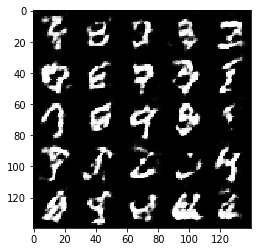

Epoch 2/2... Discriminator Loss: 1.1872... Generator Loss: 0.6782
Epoch 2/2... Discriminator Loss: 1.1305... Generator Loss: 0.7305
Epoch 2/2... Discriminator Loss: 1.1503... Generator Loss: 0.8801
Epoch 2/2... Discriminator Loss: 1.2320... Generator Loss: 0.8649
Epoch 2/2... Discriminator Loss: 1.0644... Generator Loss: 1.1030
Epoch 2/2... Discriminator Loss: 1.1496... Generator Loss: 0.9135
Epoch 2/2... Discriminator Loss: 1.2931... Generator Loss: 0.6089
Epoch 2/2... Discriminator Loss: 1.1527... Generator Loss: 0.8328
Epoch 2/2... Discriminator Loss: 1.2259... Generator Loss: 0.7647
Epoch 2/2... Discriminator Loss: 1.2103... Generator Loss: 0.9449


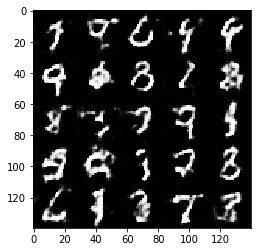

Epoch 2/2... Discriminator Loss: 1.1933... Generator Loss: 0.9177
Epoch 2/2... Discriminator Loss: 1.2890... Generator Loss: 0.5778
Epoch 2/2... Discriminator Loss: 1.3245... Generator Loss: 0.8035
Epoch 2/2... Discriminator Loss: 1.1868... Generator Loss: 0.7202
Epoch 2/2... Discriminator Loss: 1.3125... Generator Loss: 0.6558
Epoch 2/2... Discriminator Loss: 1.1982... Generator Loss: 0.8236


IndexError: list index out of range

In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(202599, 28, 28, 3)
Epoch 1/5... Discriminator Loss: 1.0094... Generator Loss: 0.7676
Epoch 1/5... Discriminator Loss: 1.0797... Generator Loss: 0.9532
Epoch 1/5... Discriminator Loss: 1.3850... Generator Loss: 0.8177
Epoch 1/5... Discriminator Loss: 1.2353... Generator Loss: 0.9744
Epoch 1/5... Discriminator Loss: 1.2140... Generator Loss: 0.9214
Epoch 1/5... Discriminator Loss: 1.2559... Generator Loss: 0.8075
Epoch 1/5... Discriminator Loss: 1.3173... Generator Loss: 0.6601
Epoch 1/5... Discriminator Loss: 1.2730... Generator Loss: 0.7584
Epoch 1/5... Discriminator Loss: 1.4442... Generator Loss: 0.6373
Epoch 1/5... Discriminator Loss: 1.2906... Generator Loss: 0.7264


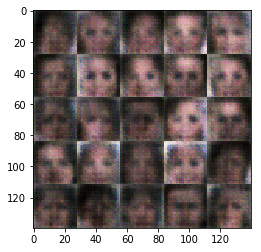

Epoch 1/5... Discriminator Loss: 1.3959... Generator Loss: 0.6516
Epoch 1/5... Discriminator Loss: 1.3804... Generator Loss: 0.7538
Epoch 1/5... Discriminator Loss: 1.3072... Generator Loss: 0.7786
Epoch 1/5... Discriminator Loss: 1.2965... Generator Loss: 0.8034
Epoch 1/5... Discriminator Loss: 1.2254... Generator Loss: 0.9257
Epoch 1/5... Discriminator Loss: 1.3313... Generator Loss: 0.8338
Epoch 1/5... Discriminator Loss: 1.4779... Generator Loss: 0.6474
Epoch 1/5... Discriminator Loss: 1.4588... Generator Loss: 0.6670
Epoch 1/5... Discriminator Loss: 1.3046... Generator Loss: 0.7399
Epoch 1/5... Discriminator Loss: 1.3294... Generator Loss: 0.7955


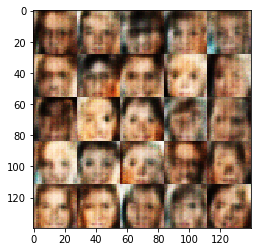

Epoch 1/5... Discriminator Loss: 1.3476... Generator Loss: 0.7416
Epoch 1/5... Discriminator Loss: 1.3736... Generator Loss: 0.6998
Epoch 1/5... Discriminator Loss: 1.3201... Generator Loss: 0.7034
Epoch 1/5... Discriminator Loss: 1.4039... Generator Loss: 0.7028
Epoch 1/5... Discriminator Loss: 1.3413... Generator Loss: 0.7022
Epoch 1/5... Discriminator Loss: 1.4351... Generator Loss: 0.7062
Epoch 1/5... Discriminator Loss: 1.3925... Generator Loss: 0.7037
Epoch 1/5... Discriminator Loss: 1.3170... Generator Loss: 0.7272
Epoch 1/5... Discriminator Loss: 1.4174... Generator Loss: 0.6827
Epoch 1/5... Discriminator Loss: 1.3753... Generator Loss: 0.6795


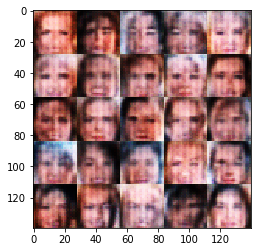

Epoch 1/5... Discriminator Loss: 1.3216... Generator Loss: 0.7237
Epoch 1/5... Discriminator Loss: 1.0613... Generator Loss: 0.7793
Epoch 1/5... Discriminator Loss: 1.3223... Generator Loss: 0.5860
Epoch 1/5... Discriminator Loss: 1.3050... Generator Loss: 0.5323
Epoch 1/5... Discriminator Loss: 0.9049... Generator Loss: 1.5525
Epoch 1/5... Discriminator Loss: 1.2712... Generator Loss: 0.9841
Epoch 1/5... Discriminator Loss: 1.4246... Generator Loss: 0.4056
Epoch 1/5... Discriminator Loss: 0.9821... Generator Loss: 1.2805
Epoch 1/5... Discriminator Loss: 1.1202... Generator Loss: 1.0289
Epoch 1/5... Discriminator Loss: 1.2772... Generator Loss: 0.9827


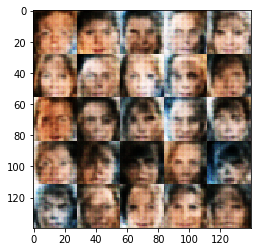

Epoch 1/5... Discriminator Loss: 1.2451... Generator Loss: 1.1735
Epoch 1/5... Discriminator Loss: 1.2171... Generator Loss: 0.7590
Epoch 1/5... Discriminator Loss: 0.8638... Generator Loss: 1.5778
Epoch 1/5... Discriminator Loss: 1.0864... Generator Loss: 1.1600
Epoch 1/5... Discriminator Loss: 1.4586... Generator Loss: 0.4202
Epoch 1/5... Discriminator Loss: 1.0111... Generator Loss: 0.8364
Epoch 1/5... Discriminator Loss: 1.1137... Generator Loss: 1.1266
Epoch 1/5... Discriminator Loss: 1.2071... Generator Loss: 0.9760
Epoch 1/5... Discriminator Loss: 1.0190... Generator Loss: 1.1294
Epoch 1/5... Discriminator Loss: 1.4865... Generator Loss: 0.3885


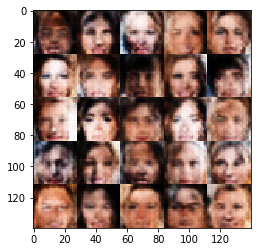

Epoch 1/5... Discriminator Loss: 1.2088... Generator Loss: 0.6561
Epoch 1/5... Discriminator Loss: 1.0499... Generator Loss: 1.0035
Epoch 1/5... Discriminator Loss: 0.9024... Generator Loss: 1.1877
Epoch 1/5... Discriminator Loss: 1.3582... Generator Loss: 0.7354
Epoch 1/5... Discriminator Loss: 1.1047... Generator Loss: 0.9950
Epoch 1/5... Discriminator Loss: 1.2069... Generator Loss: 0.8261
Epoch 1/5... Discriminator Loss: 1.3398... Generator Loss: 0.7497
Epoch 1/5... Discriminator Loss: 1.1779... Generator Loss: 0.8526
Epoch 1/5... Discriminator Loss: 1.2210... Generator Loss: 0.8756
Epoch 1/5... Discriminator Loss: 1.0401... Generator Loss: 0.9134


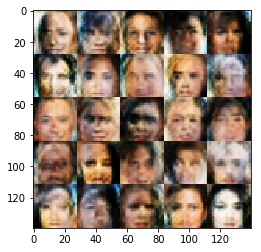

Epoch 1/5... Discriminator Loss: 1.3551... Generator Loss: 0.4951
Epoch 1/5... Discriminator Loss: 1.3607... Generator Loss: 0.7785
Epoch 1/5... Discriminator Loss: 1.3631... Generator Loss: 0.6089
Epoch 1/5... Discriminator Loss: 1.1604... Generator Loss: 0.8699
Epoch 1/5... Discriminator Loss: 1.1749... Generator Loss: 0.8353
Epoch 1/5... Discriminator Loss: 1.2368... Generator Loss: 0.9909
Epoch 1/5... Discriminator Loss: 1.3633... Generator Loss: 0.8372
Epoch 1/5... Discriminator Loss: 1.2835... Generator Loss: 0.7671
Epoch 1/5... Discriminator Loss: 1.2864... Generator Loss: 0.7955
Epoch 1/5... Discriminator Loss: 1.2969... Generator Loss: 0.7635


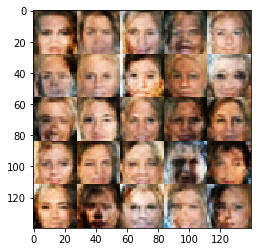

Epoch 1/5... Discriminator Loss: 1.2930... Generator Loss: 0.7113
Epoch 1/5... Discriminator Loss: 1.2828... Generator Loss: 0.7485
Epoch 1/5... Discriminator Loss: 1.3159... Generator Loss: 0.8090
Epoch 1/5... Discriminator Loss: 1.1743... Generator Loss: 0.8053
Epoch 1/5... Discriminator Loss: 1.2671... Generator Loss: 0.9274
Epoch 1/5... Discriminator Loss: 1.1706... Generator Loss: 0.8876
Epoch 1/5... Discriminator Loss: 1.5210... Generator Loss: 0.4608
Epoch 1/5... Discriminator Loss: 1.3372... Generator Loss: 0.6447
Epoch 1/5... Discriminator Loss: 1.2901... Generator Loss: 0.7299
Epoch 2/5... Discriminator Loss: 1.2746... Generator Loss: 0.7958


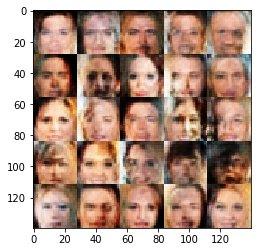

Epoch 2/5... Discriminator Loss: 1.3256... Generator Loss: 0.7289
Epoch 2/5... Discriminator Loss: 1.3220... Generator Loss: 0.7047
Epoch 2/5... Discriminator Loss: 1.4091... Generator Loss: 0.6574
Epoch 2/5... Discriminator Loss: 1.3053... Generator Loss: 0.7598
Epoch 2/5... Discriminator Loss: 1.2873... Generator Loss: 0.7747
Epoch 2/5... Discriminator Loss: 1.2700... Generator Loss: 0.8768
Epoch 2/5... Discriminator Loss: 1.0709... Generator Loss: 1.0058
Epoch 2/5... Discriminator Loss: 1.5588... Generator Loss: 0.3940
Epoch 2/5... Discriminator Loss: 1.1532... Generator Loss: 1.0301
Epoch 2/5... Discriminator Loss: 1.2920... Generator Loss: 0.7554


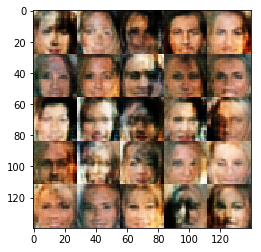

Epoch 2/5... Discriminator Loss: 1.3554... Generator Loss: 0.7398
Epoch 2/5... Discriminator Loss: 1.1780... Generator Loss: 0.8202
Epoch 2/5... Discriminator Loss: 1.1795... Generator Loss: 0.7952
Epoch 2/5... Discriminator Loss: 1.1896... Generator Loss: 0.8505
Epoch 2/5... Discriminator Loss: 1.0028... Generator Loss: 1.0498
Epoch 2/5... Discriminator Loss: 1.2542... Generator Loss: 0.7754
Epoch 2/5... Discriminator Loss: 1.0219... Generator Loss: 1.0282
Epoch 2/5... Discriminator Loss: 1.1734... Generator Loss: 0.9522
Epoch 2/5... Discriminator Loss: 1.5595... Generator Loss: 0.4069
Epoch 2/5... Discriminator Loss: 0.9700... Generator Loss: 0.8972


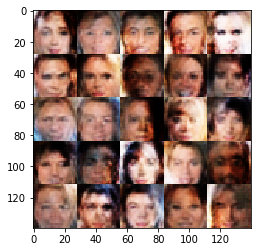

Epoch 2/5... Discriminator Loss: 1.0079... Generator Loss: 1.3200
Epoch 2/5... Discriminator Loss: 1.0591... Generator Loss: 0.9135
Epoch 2/5... Discriminator Loss: 1.0271... Generator Loss: 1.0068
Epoch 2/5... Discriminator Loss: 1.2377... Generator Loss: 0.6447
Epoch 2/5... Discriminator Loss: 1.1626... Generator Loss: 0.6877
Epoch 2/5... Discriminator Loss: 1.0594... Generator Loss: 0.9476
Epoch 2/5... Discriminator Loss: 1.1024... Generator Loss: 0.8781
Epoch 2/5... Discriminator Loss: 0.8834... Generator Loss: 1.4182
Epoch 2/5... Discriminator Loss: 1.0248... Generator Loss: 1.2542
Epoch 2/5... Discriminator Loss: 1.3104... Generator Loss: 0.7486


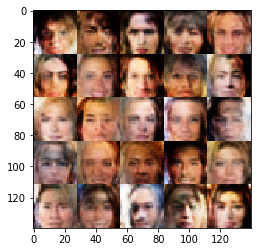

Epoch 2/5... Discriminator Loss: 0.9740... Generator Loss: 1.1400
Epoch 2/5... Discriminator Loss: 1.0573... Generator Loss: 0.9683
Epoch 2/5... Discriminator Loss: 0.9765... Generator Loss: 1.6779
Epoch 2/5... Discriminator Loss: 0.9141... Generator Loss: 1.1213
Epoch 2/5... Discriminator Loss: 1.0073... Generator Loss: 0.8729
Epoch 2/5... Discriminator Loss: 1.0361... Generator Loss: 1.5983
Epoch 2/5... Discriminator Loss: 1.0844... Generator Loss: 1.1299
Epoch 2/5... Discriminator Loss: 1.0495... Generator Loss: 1.0218
Epoch 2/5... Discriminator Loss: 1.0189... Generator Loss: 0.8306
Epoch 2/5... Discriminator Loss: 1.0540... Generator Loss: 1.8242


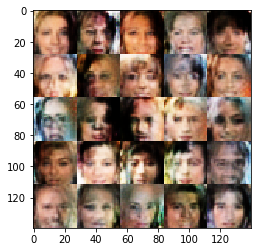

Epoch 2/5... Discriminator Loss: 0.9174... Generator Loss: 1.5704
Epoch 2/5... Discriminator Loss: 0.8145... Generator Loss: 1.5095
Epoch 2/5... Discriminator Loss: 0.9454... Generator Loss: 1.0662
Epoch 2/5... Discriminator Loss: 1.1607... Generator Loss: 0.7282
Epoch 2/5... Discriminator Loss: 1.0234... Generator Loss: 1.1044
Epoch 2/5... Discriminator Loss: 0.9461... Generator Loss: 1.0571
Epoch 2/5... Discriminator Loss: 1.0108... Generator Loss: 1.2067
Epoch 2/5... Discriminator Loss: 1.1139... Generator Loss: 0.6382
Epoch 2/5... Discriminator Loss: 1.0742... Generator Loss: 0.8999
Epoch 2/5... Discriminator Loss: 1.0977... Generator Loss: 0.9855


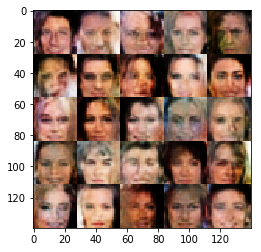

Epoch 2/5... Discriminator Loss: 1.1732... Generator Loss: 0.6677
Epoch 2/5... Discriminator Loss: 1.0831... Generator Loss: 1.1412
Epoch 2/5... Discriminator Loss: 1.0491... Generator Loss: 1.2213
Epoch 2/5... Discriminator Loss: 0.9440... Generator Loss: 0.9602
Epoch 2/5... Discriminator Loss: 0.9047... Generator Loss: 1.1373
Epoch 2/5... Discriminator Loss: 1.0800... Generator Loss: 1.0169
Epoch 2/5... Discriminator Loss: 1.0354... Generator Loss: 0.9741
Epoch 2/5... Discriminator Loss: 0.9207... Generator Loss: 1.2537
Epoch 2/5... Discriminator Loss: 0.9359... Generator Loss: 1.0829
Epoch 2/5... Discriminator Loss: 1.1912... Generator Loss: 0.9439


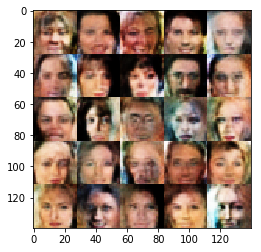

Epoch 2/5... Discriminator Loss: 0.9544... Generator Loss: 1.2434
Epoch 2/5... Discriminator Loss: 1.0350... Generator Loss: 0.8291
Epoch 2/5... Discriminator Loss: 1.2006... Generator Loss: 0.8471
Epoch 2/5... Discriminator Loss: 1.1988... Generator Loss: 1.1949
Epoch 2/5... Discriminator Loss: 1.1323... Generator Loss: 0.7548
Epoch 2/5... Discriminator Loss: 0.9662... Generator Loss: 1.0972
Epoch 2/5... Discriminator Loss: 1.0419... Generator Loss: 0.8647
Epoch 2/5... Discriminator Loss: 1.0092... Generator Loss: 1.4132
Epoch 2/5... Discriminator Loss: 0.9904... Generator Loss: 1.3019
Epoch 2/5... Discriminator Loss: 0.9939... Generator Loss: 1.6142


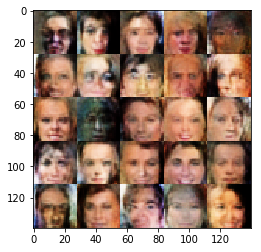

Epoch 2/5... Discriminator Loss: 0.9432... Generator Loss: 1.6498
Epoch 2/5... Discriminator Loss: 1.0081... Generator Loss: 1.1122
Epoch 2/5... Discriminator Loss: 1.1652... Generator Loss: 0.7224
Epoch 2/5... Discriminator Loss: 1.0595... Generator Loss: 0.9387
Epoch 2/5... Discriminator Loss: 1.1047... Generator Loss: 0.8107
Epoch 2/5... Discriminator Loss: 1.0135... Generator Loss: 0.7505
Epoch 2/5... Discriminator Loss: 1.1605... Generator Loss: 1.1919
Epoch 2/5... Discriminator Loss: 1.0925... Generator Loss: 1.0275
Epoch 3/5... Discriminator Loss: 0.9104... Generator Loss: 1.4860
Epoch 3/5... Discriminator Loss: 0.9983... Generator Loss: 1.0849


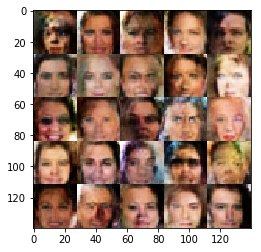

Epoch 3/5... Discriminator Loss: 1.1053... Generator Loss: 0.7849
Epoch 3/5... Discriminator Loss: 1.0156... Generator Loss: 0.8163
Epoch 3/5... Discriminator Loss: 1.2997... Generator Loss: 0.5490
Epoch 3/5... Discriminator Loss: 1.0004... Generator Loss: 0.9397
Epoch 3/5... Discriminator Loss: 0.9117... Generator Loss: 1.2405
Epoch 3/5... Discriminator Loss: 1.1374... Generator Loss: 0.9146
Epoch 3/5... Discriminator Loss: 1.0917... Generator Loss: 0.8373
Epoch 3/5... Discriminator Loss: 0.9790... Generator Loss: 0.9123
Epoch 3/5... Discriminator Loss: 1.1180... Generator Loss: 1.3898
Epoch 3/5... Discriminator Loss: 0.9202... Generator Loss: 1.0813


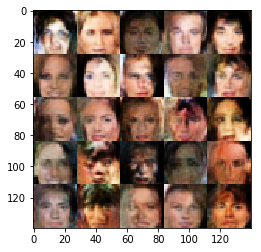

Epoch 3/5... Discriminator Loss: 1.1833... Generator Loss: 0.7538
Epoch 3/5... Discriminator Loss: 1.1020... Generator Loss: 1.3421
Epoch 3/5... Discriminator Loss: 1.0507... Generator Loss: 1.3206
Epoch 3/5... Discriminator Loss: 1.0177... Generator Loss: 1.0119
Epoch 3/5... Discriminator Loss: 1.0499... Generator Loss: 1.3541
Epoch 3/5... Discriminator Loss: 1.0361... Generator Loss: 1.2509
Epoch 3/5... Discriminator Loss: 0.9743... Generator Loss: 1.0580
Epoch 3/5... Discriminator Loss: 1.1918... Generator Loss: 0.6191
Epoch 3/5... Discriminator Loss: 1.3282... Generator Loss: 0.5424
Epoch 3/5... Discriminator Loss: 1.0006... Generator Loss: 1.6872


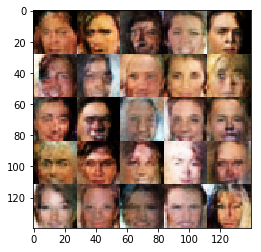

Epoch 3/5... Discriminator Loss: 1.0643... Generator Loss: 1.2344
Epoch 3/5... Discriminator Loss: 1.2011... Generator Loss: 0.8283
Epoch 3/5... Discriminator Loss: 1.1833... Generator Loss: 1.2080
Epoch 3/5... Discriminator Loss: 1.1229... Generator Loss: 0.8434
Epoch 3/5... Discriminator Loss: 1.0359... Generator Loss: 1.0277
Epoch 3/5... Discriminator Loss: 1.0343... Generator Loss: 1.0598
Epoch 3/5... Discriminator Loss: 1.0346... Generator Loss: 1.0775
Epoch 3/5... Discriminator Loss: 0.9829... Generator Loss: 1.1897
Epoch 3/5... Discriminator Loss: 1.0157... Generator Loss: 0.9518
Epoch 3/5... Discriminator Loss: 0.9376... Generator Loss: 1.4448


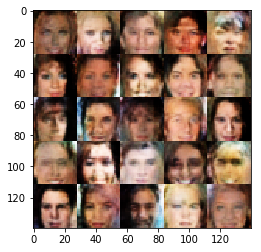

Epoch 3/5... Discriminator Loss: 1.1061... Generator Loss: 1.0036
Epoch 3/5... Discriminator Loss: 1.0643... Generator Loss: 1.0286
Epoch 3/5... Discriminator Loss: 1.2992... Generator Loss: 0.5029
Epoch 3/5... Discriminator Loss: 1.1130... Generator Loss: 1.2732
Epoch 3/5... Discriminator Loss: 1.1245... Generator Loss: 0.6991
Epoch 3/5... Discriminator Loss: 0.9128... Generator Loss: 1.4985
Epoch 3/5... Discriminator Loss: 1.0110... Generator Loss: 1.5500
Epoch 3/5... Discriminator Loss: 0.9630... Generator Loss: 0.9139
Epoch 3/5... Discriminator Loss: 1.0134... Generator Loss: 1.1989
Epoch 3/5... Discriminator Loss: 1.3625... Generator Loss: 0.4678


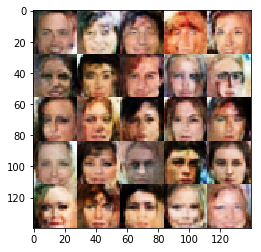

Epoch 3/5... Discriminator Loss: 0.9599... Generator Loss: 1.2456
Epoch 3/5... Discriminator Loss: 0.9124... Generator Loss: 0.9337
Epoch 3/5... Discriminator Loss: 0.9685... Generator Loss: 1.1977
Epoch 3/5... Discriminator Loss: 1.0330... Generator Loss: 0.9222
Epoch 3/5... Discriminator Loss: 0.9643... Generator Loss: 1.6251
Epoch 3/5... Discriminator Loss: 1.1987... Generator Loss: 1.0681
Epoch 3/5... Discriminator Loss: 1.0430... Generator Loss: 1.1521
Epoch 3/5... Discriminator Loss: 1.1025... Generator Loss: 0.9409
Epoch 3/5... Discriminator Loss: 1.0940... Generator Loss: 0.8159
Epoch 3/5... Discriminator Loss: 1.0764... Generator Loss: 0.7742


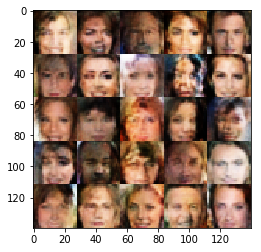

Epoch 3/5... Discriminator Loss: 0.8980... Generator Loss: 1.0413
Epoch 3/5... Discriminator Loss: 0.8593... Generator Loss: 1.2298
Epoch 3/5... Discriminator Loss: 0.9193... Generator Loss: 1.3448
Epoch 3/5... Discriminator Loss: 1.0396... Generator Loss: 1.0630
Epoch 3/5... Discriminator Loss: 0.7873... Generator Loss: 1.7768
Epoch 3/5... Discriminator Loss: 1.0136... Generator Loss: 1.4728
Epoch 3/5... Discriminator Loss: 1.1583... Generator Loss: 1.0920
Epoch 3/5... Discriminator Loss: 1.1487... Generator Loss: 1.5176
Epoch 3/5... Discriminator Loss: 1.0904... Generator Loss: 1.1617
Epoch 3/5... Discriminator Loss: 0.9972... Generator Loss: 1.4213


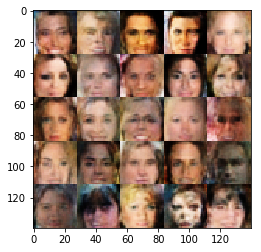

Epoch 3/5... Discriminator Loss: 0.9122... Generator Loss: 1.1401
Epoch 3/5... Discriminator Loss: 1.0345... Generator Loss: 1.6658
Epoch 3/5... Discriminator Loss: 1.1519... Generator Loss: 1.3909
Epoch 3/5... Discriminator Loss: 1.0338... Generator Loss: 1.0830
Epoch 3/5... Discriminator Loss: 0.7137... Generator Loss: 1.5694
Epoch 3/5... Discriminator Loss: 0.9449... Generator Loss: 1.3849
Epoch 3/5... Discriminator Loss: 0.9844... Generator Loss: 1.4771
Epoch 3/5... Discriminator Loss: 0.8909... Generator Loss: 1.2924
Epoch 3/5... Discriminator Loss: 1.1458... Generator Loss: 0.7776
Epoch 3/5... Discriminator Loss: 1.0626... Generator Loss: 1.2096


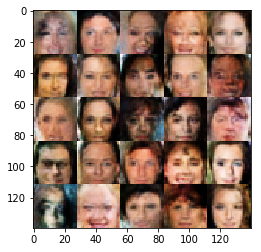

Epoch 3/5... Discriminator Loss: 1.0931... Generator Loss: 0.6762
Epoch 3/5... Discriminator Loss: 0.8913... Generator Loss: 1.6848
Epoch 3/5... Discriminator Loss: 0.4976... Generator Loss: 2.6110
Epoch 3/5... Discriminator Loss: 1.1509... Generator Loss: 0.6797
Epoch 3/5... Discriminator Loss: 0.8977... Generator Loss: 1.3121
Epoch 3/5... Discriminator Loss: 1.1356... Generator Loss: 0.6709
Epoch 3/5... Discriminator Loss: 0.8471... Generator Loss: 0.9292
Epoch 4/5... Discriminator Loss: 1.0889... Generator Loss: 1.3072
Epoch 4/5... Discriminator Loss: 0.9025... Generator Loss: 1.2426
Epoch 4/5... Discriminator Loss: 1.0851... Generator Loss: 0.9049


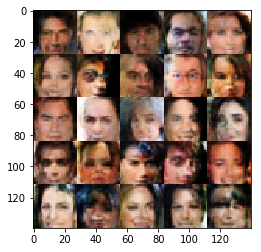

Epoch 4/5... Discriminator Loss: 1.0670... Generator Loss: 1.4248
Epoch 4/5... Discriminator Loss: 0.9030... Generator Loss: 1.2658
Epoch 4/5... Discriminator Loss: 1.0386... Generator Loss: 1.7033
Epoch 4/5... Discriminator Loss: 1.0167... Generator Loss: 1.3128
Epoch 4/5... Discriminator Loss: 1.0882... Generator Loss: 0.8536
Epoch 4/5... Discriminator Loss: 1.0763... Generator Loss: 0.6746
Epoch 4/5... Discriminator Loss: 0.7909... Generator Loss: 1.4423
Epoch 4/5... Discriminator Loss: 0.9229... Generator Loss: 1.6288
Epoch 4/5... Discriminator Loss: 1.1776... Generator Loss: 0.7812
Epoch 4/5... Discriminator Loss: 0.8294... Generator Loss: 1.4989


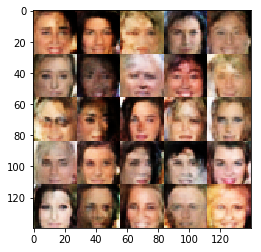

Epoch 4/5... Discriminator Loss: 0.8727... Generator Loss: 0.9553
Epoch 4/5... Discriminator Loss: 0.9760... Generator Loss: 1.2895
Epoch 4/5... Discriminator Loss: 0.9461... Generator Loss: 1.3805
Epoch 4/5... Discriminator Loss: 0.9583... Generator Loss: 1.6918
Epoch 4/5... Discriminator Loss: 0.8289... Generator Loss: 1.3722
Epoch 4/5... Discriminator Loss: 0.9454... Generator Loss: 0.9176
Epoch 4/5... Discriminator Loss: 0.8820... Generator Loss: 1.0043
Epoch 4/5... Discriminator Loss: 0.8942... Generator Loss: 1.4634
Epoch 4/5... Discriminator Loss: 1.1116... Generator Loss: 0.8673
Epoch 4/5... Discriminator Loss: 0.8285... Generator Loss: 1.1553


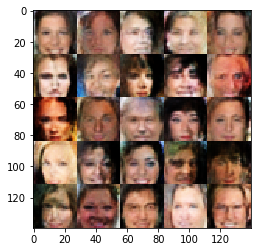

Epoch 4/5... Discriminator Loss: 1.0993... Generator Loss: 0.6894
Epoch 4/5... Discriminator Loss: 0.9747... Generator Loss: 1.6385
Epoch 4/5... Discriminator Loss: 1.1250... Generator Loss: 0.6722
Epoch 4/5... Discriminator Loss: 1.0139... Generator Loss: 0.7882
Epoch 4/5... Discriminator Loss: 1.0017... Generator Loss: 0.9187
Epoch 4/5... Discriminator Loss: 0.8986... Generator Loss: 1.0493
Epoch 4/5... Discriminator Loss: 0.9773... Generator Loss: 1.0231
Epoch 4/5... Discriminator Loss: 1.1279... Generator Loss: 0.6777
Epoch 4/5... Discriminator Loss: 0.9485... Generator Loss: 1.4099
Epoch 4/5... Discriminator Loss: 1.0948... Generator Loss: 0.8862


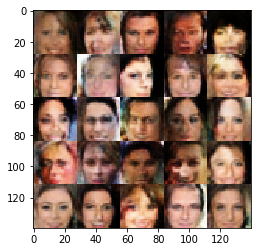

Epoch 4/5... Discriminator Loss: 0.6919... Generator Loss: 2.0859
Epoch 4/5... Discriminator Loss: 1.0505... Generator Loss: 0.9694
Epoch 4/5... Discriminator Loss: 1.0066... Generator Loss: 1.0661
Epoch 4/5... Discriminator Loss: 0.8730... Generator Loss: 1.0908
Epoch 4/5... Discriminator Loss: 0.9674... Generator Loss: 1.2592
Epoch 4/5... Discriminator Loss: 1.2388... Generator Loss: 0.5413
Epoch 4/5... Discriminator Loss: 0.8723... Generator Loss: 1.0559
Epoch 4/5... Discriminator Loss: 0.8763... Generator Loss: 1.2011
Epoch 4/5... Discriminator Loss: 0.9044... Generator Loss: 1.1699
Epoch 4/5... Discriminator Loss: 1.3135... Generator Loss: 1.2718


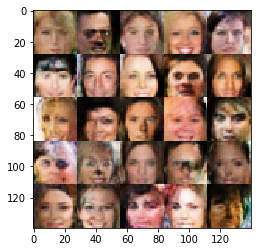

Epoch 4/5... Discriminator Loss: 1.2724... Generator Loss: 0.5061
Epoch 4/5... Discriminator Loss: 1.0168... Generator Loss: 1.0997
Epoch 4/5... Discriminator Loss: 0.8609... Generator Loss: 1.3363
Epoch 4/5... Discriminator Loss: 1.0454... Generator Loss: 0.8391
Epoch 4/5... Discriminator Loss: 1.0412... Generator Loss: 1.0500
Epoch 4/5... Discriminator Loss: 0.9854... Generator Loss: 1.2746
Epoch 4/5... Discriminator Loss: 1.0428... Generator Loss: 0.9674
Epoch 4/5... Discriminator Loss: 0.8862... Generator Loss: 1.5876
Epoch 4/5... Discriminator Loss: 1.1253... Generator Loss: 0.8896
Epoch 4/5... Discriminator Loss: 0.7147... Generator Loss: 1.6636


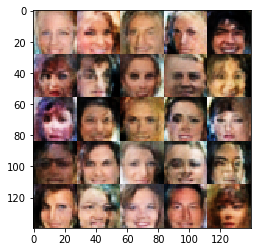

Epoch 4/5... Discriminator Loss: 0.8896... Generator Loss: 1.1998
Epoch 4/5... Discriminator Loss: 0.7773... Generator Loss: 2.3051
Epoch 4/5... Discriminator Loss: 1.1630... Generator Loss: 0.6964
Epoch 4/5... Discriminator Loss: 1.0254... Generator Loss: 0.8061
Epoch 4/5... Discriminator Loss: 0.9234... Generator Loss: 1.0964
Epoch 4/5... Discriminator Loss: 0.9415... Generator Loss: 0.8433
Epoch 4/5... Discriminator Loss: 0.9914... Generator Loss: 0.9446
Epoch 4/5... Discriminator Loss: 0.9124... Generator Loss: 1.3628
Epoch 4/5... Discriminator Loss: 1.0767... Generator Loss: 0.9883
Epoch 4/5... Discriminator Loss: 1.1244... Generator Loss: 0.6099


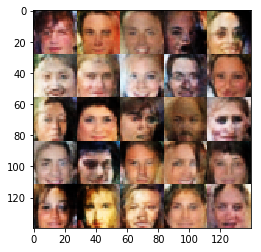

Epoch 4/5... Discriminator Loss: 0.8155... Generator Loss: 1.6017
Epoch 4/5... Discriminator Loss: 0.9803... Generator Loss: 1.0719
Epoch 4/5... Discriminator Loss: 1.0337... Generator Loss: 0.8070
Epoch 4/5... Discriminator Loss: 0.8851... Generator Loss: 1.0018
Epoch 4/5... Discriminator Loss: 0.9151... Generator Loss: 1.3042
Epoch 4/5... Discriminator Loss: 1.0612... Generator Loss: 0.9568
Epoch 4/5... Discriminator Loss: 0.9755... Generator Loss: 0.8663
Epoch 4/5... Discriminator Loss: 1.1198... Generator Loss: 0.6465
Epoch 4/5... Discriminator Loss: 1.0962... Generator Loss: 0.6555
Epoch 4/5... Discriminator Loss: 0.8474... Generator Loss: 1.4846


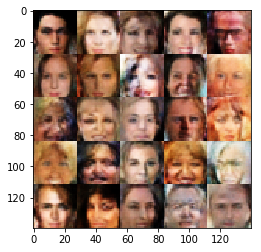

Epoch 4/5... Discriminator Loss: 1.1757... Generator Loss: 0.6011
Epoch 4/5... Discriminator Loss: 0.9323... Generator Loss: 1.3495
Epoch 4/5... Discriminator Loss: 1.0583... Generator Loss: 1.8411
Epoch 4/5... Discriminator Loss: 1.2635... Generator Loss: 0.5415
Epoch 4/5... Discriminator Loss: 1.0228... Generator Loss: 1.0334
Epoch 4/5... Discriminator Loss: 1.0305... Generator Loss: 0.9210
Epoch 5/5... Discriminator Loss: 1.1592... Generator Loss: 0.6346
Epoch 5/5... Discriminator Loss: 0.8524... Generator Loss: 1.0544
Epoch 5/5... Discriminator Loss: 1.0223... Generator Loss: 0.7413
Epoch 5/5... Discriminator Loss: 0.8738... Generator Loss: 2.2123


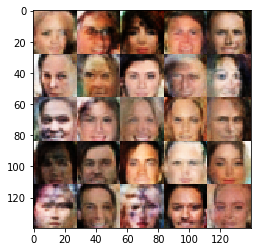

Epoch 5/5... Discriminator Loss: 1.1678... Generator Loss: 0.7649
Epoch 5/5... Discriminator Loss: 0.7653... Generator Loss: 1.4624
Epoch 5/5... Discriminator Loss: 0.9831... Generator Loss: 1.2147
Epoch 5/5... Discriminator Loss: 1.0116... Generator Loss: 0.9663
Epoch 5/5... Discriminator Loss: 1.0259... Generator Loss: 0.9552
Epoch 5/5... Discriminator Loss: 1.0540... Generator Loss: 1.0358
Epoch 5/5... Discriminator Loss: 0.7925... Generator Loss: 1.0965
Epoch 5/5... Discriminator Loss: 1.0174... Generator Loss: 0.8997
Epoch 5/5... Discriminator Loss: 0.9122... Generator Loss: 1.3827
Epoch 5/5... Discriminator Loss: 1.0647... Generator Loss: 0.7081


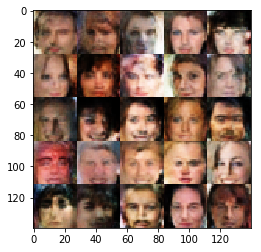

Epoch 5/5... Discriminator Loss: 0.9556... Generator Loss: 0.9883
Epoch 5/5... Discriminator Loss: 0.8278... Generator Loss: 1.1014
Epoch 5/5... Discriminator Loss: 0.9922... Generator Loss: 0.9805
Epoch 5/5... Discriminator Loss: 0.9384... Generator Loss: 1.0668
Epoch 5/5... Discriminator Loss: 1.3802... Generator Loss: 0.4279
Epoch 5/5... Discriminator Loss: 0.9916... Generator Loss: 1.3025
Epoch 5/5... Discriminator Loss: 1.1178... Generator Loss: 1.3565
Epoch 5/5... Discriminator Loss: 1.1024... Generator Loss: 0.8811
Epoch 5/5... Discriminator Loss: 0.9096... Generator Loss: 1.3543
Epoch 5/5... Discriminator Loss: 1.1042... Generator Loss: 0.7104


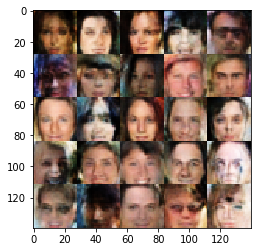

Epoch 5/5... Discriminator Loss: 1.0885... Generator Loss: 0.6767
Epoch 5/5... Discriminator Loss: 0.9157... Generator Loss: 1.3660
Epoch 5/5... Discriminator Loss: 1.0894... Generator Loss: 0.7486
Epoch 5/5... Discriminator Loss: 1.2396... Generator Loss: 0.5212
Epoch 5/5... Discriminator Loss: 0.9701... Generator Loss: 1.0464
Epoch 5/5... Discriminator Loss: 0.9240... Generator Loss: 1.0727
Epoch 5/5... Discriminator Loss: 0.8600... Generator Loss: 1.5000
Epoch 5/5... Discriminator Loss: 1.0273... Generator Loss: 0.8818
Epoch 5/5... Discriminator Loss: 1.0845... Generator Loss: 0.8016
Epoch 5/5... Discriminator Loss: 1.1243... Generator Loss: 0.7040


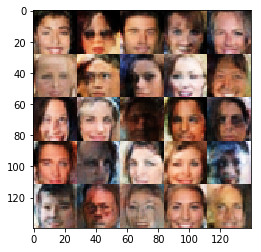

Epoch 5/5... Discriminator Loss: 1.0384... Generator Loss: 0.9608
Epoch 5/5... Discriminator Loss: 0.7378... Generator Loss: 1.5961
Epoch 5/5... Discriminator Loss: 0.7988... Generator Loss: 1.5863
Epoch 5/5... Discriminator Loss: 1.1003... Generator Loss: 1.0966
Epoch 5/5... Discriminator Loss: 0.9144... Generator Loss: 1.0635
Epoch 5/5... Discriminator Loss: 1.0356... Generator Loss: 0.8220
Epoch 5/5... Discriminator Loss: 0.8692... Generator Loss: 1.2884
Epoch 5/5... Discriminator Loss: 1.0378... Generator Loss: 1.4328
Epoch 5/5... Discriminator Loss: 0.7613... Generator Loss: 1.6526
Epoch 5/5... Discriminator Loss: 0.8260... Generator Loss: 1.5277


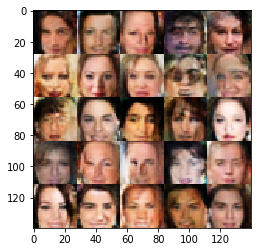

Epoch 5/5... Discriminator Loss: 1.0521... Generator Loss: 0.8072
Epoch 5/5... Discriminator Loss: 0.8745... Generator Loss: 1.5490
Epoch 5/5... Discriminator Loss: 1.0016... Generator Loss: 1.1249
Epoch 5/5... Discriminator Loss: 1.1260... Generator Loss: 1.1091
Epoch 5/5... Discriminator Loss: 1.1352... Generator Loss: 0.9110
Epoch 5/5... Discriminator Loss: 1.1480... Generator Loss: 0.7230
Epoch 5/5... Discriminator Loss: 1.1354... Generator Loss: 1.4330
Epoch 5/5... Discriminator Loss: 0.9131... Generator Loss: 0.8971
Epoch 5/5... Discriminator Loss: 0.9952... Generator Loss: 1.0050
Epoch 5/5... Discriminator Loss: 0.8527... Generator Loss: 1.3346


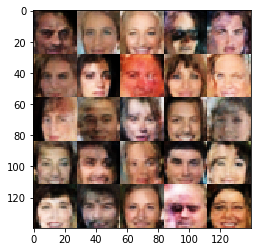

Epoch 5/5... Discriminator Loss: 1.0177... Generator Loss: 1.0855
Epoch 5/5... Discriminator Loss: 0.9345... Generator Loss: 1.1363
Epoch 5/5... Discriminator Loss: 1.0997... Generator Loss: 0.8806
Epoch 5/5... Discriminator Loss: 1.0712... Generator Loss: 1.1231
Epoch 5/5... Discriminator Loss: 1.0461... Generator Loss: 1.9533
Epoch 5/5... Discriminator Loss: 0.8019... Generator Loss: 1.2964
Epoch 5/5... Discriminator Loss: 1.0785... Generator Loss: 1.0462
Epoch 5/5... Discriminator Loss: 1.1959... Generator Loss: 0.7013
Epoch 5/5... Discriminator Loss: 1.0268... Generator Loss: 1.1522
Epoch 5/5... Discriminator Loss: 1.0290... Generator Loss: 1.0537


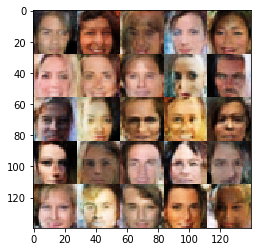

Epoch 5/5... Discriminator Loss: 1.1456... Generator Loss: 0.8993
Epoch 5/5... Discriminator Loss: 0.9870... Generator Loss: 0.9360
Epoch 5/5... Discriminator Loss: 0.9890... Generator Loss: 0.8293
Epoch 5/5... Discriminator Loss: 1.0369... Generator Loss: 1.0177
Epoch 5/5... Discriminator Loss: 1.1572... Generator Loss: 0.6065
Epoch 5/5... Discriminator Loss: 0.8359... Generator Loss: 1.5676
Epoch 5/5... Discriminator Loss: 1.1134... Generator Loss: 1.4523
Epoch 5/5... Discriminator Loss: 0.8530... Generator Loss: 2.3375
Epoch 5/5... Discriminator Loss: 0.7683... Generator Loss: 1.4621
Epoch 5/5... Discriminator Loss: 1.0946... Generator Loss: 1.1133


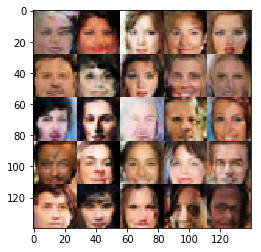

Epoch 5/5... Discriminator Loss: 0.7739... Generator Loss: 1.2676
Epoch 5/5... Discriminator Loss: 1.1049... Generator Loss: 1.2937
Epoch 5/5... Discriminator Loss: 0.9558... Generator Loss: 1.3213
Epoch 5/5... Discriminator Loss: 0.8759... Generator Loss: 1.3220
Epoch 5/5... Discriminator Loss: 1.3276... Generator Loss: 0.5180


IndexError: list index out of range

In [24]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 5

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.